In [1]:
import pandas as pd
import numpy as np
import requests
import shelve
import os
from datetime import datetime
import matplotlib.pyplot as plt

Reading CSV file: c:\Users\asus\OneDrive - purdue.edu\VS code\Data\SDUD\SDUD2022.csv
Total rows in 2022 before filtering: 5164804
Rows after removing NA: 2621949
Rows after filtering State='XX': 2389418
Unique NDCs: 33005
Saved 2389418 NDC values to c:\Users\asus\OneDrive - purdue.edu\VS code\Data\ATC\text_files\NDCf_2022.txt
Unique NDC values: 33005
Unique ATC4 Classes: 606
Unique NDCs in ATC4 mapping: 30846
NDCs without ATC4 Class: 2159
NDCs with ATC4 Class: 30846
Saved missing NDCs to c:\Users\asus\OneDrive - purdue.edu\VS code\Data\ATC\text_files\NDC_missing_2022.txt
Using cache: c:\Users\asus\OneDrive - purdue.edu\VS code\Data\ATC\cache_files\atc_names_cache
Reading c:\Users\asus\OneDrive - purdue.edu\VS code\Data\ATC\NDCf_2022_ATC4_classes.csv...
Total rows: 59754
Original columns: ['NDC', 'ATC4 Class']

Creating ATC3 and ATC2 columns from ATC4...
  ATC4 Class ATC3 Class ATC2 Class
0      N06BA       N06B        N06
1      A06AX       A06A        A06
2      M01AE       M01A      

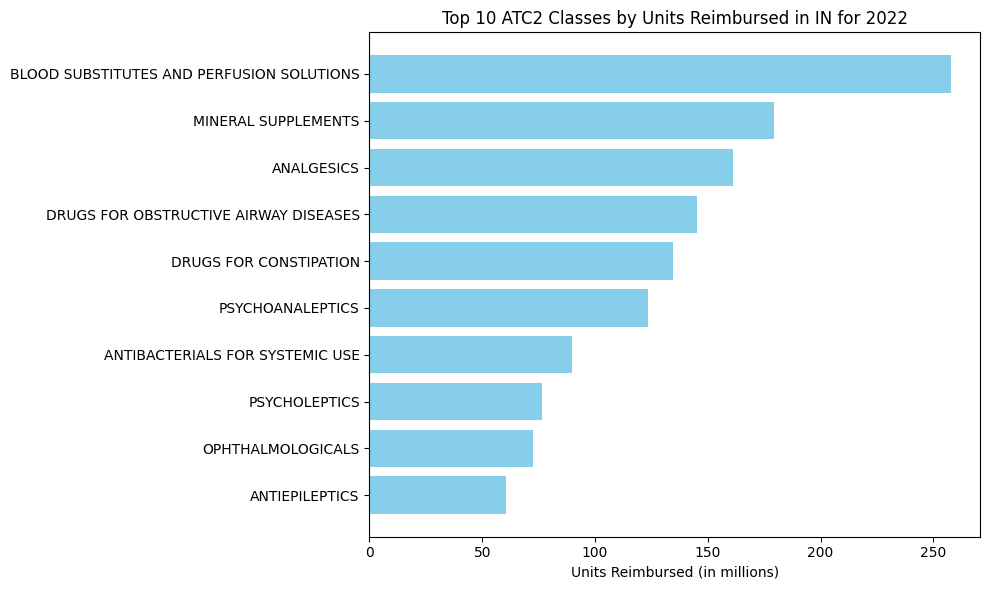

In [3]:

class NDCATCAnalyzer:

    """Analyzes SDUD data and maps NDC codes to ATC classes."""
    
    def __init__(self, year, base_path=None):
        """
        Initialize the analyzer.
        
        Args:
            year: Year of SDUD data to analyze
            base_path: Base directory path (defaults to standard location)
        """
        self.year = year
        if base_path is None:
            #Lookup the user's base path!
            self.base_path = r"c:\Users\asus\OneDrive - purdue.edu\VS code\Data"
        else:
            self.base_path = base_path
            
        self.df_cleaned = None
        self.df_merged = None
        self.atc_mapping = None
        
    def clean_sdud_data(self):
        """Step 1: Read and clean SDUD dataset."""
        csv_file = os.path.join(self.base_path, f"SDUD\\SDUD{self.year}.csv")
        print(f"Reading CSV file: {csv_file}")
        
        # Read with NDC as string to preserve leading zeros
        df = pd.read_csv(csv_file, dtype={'NDC': 'object'})
        
        print(f"Total rows in {self.year} before filtering: {len(df)}")
        
        # Remove NA values
        df_filtered = df.dropna(subset=['Units Reimbursed', 'Number of Prescriptions'])
        print(f"Rows after removing NA: {len(df_filtered)}")
        
        # Filter out State='XX'
        df_filtered = df_filtered[df_filtered['State'] != 'XX']
        print(f"Rows after filtering State='XX': {len(df_filtered)}")
        print(f"Unique NDCs: {df_filtered['NDC'].nunique()}")
        
        self.df_cleaned = df_filtered
        return self.df_cleaned
    
    def generate_ndc_txt(self, output_filename=None):
        """Step 2: Generate text file with unique NDC values."""
        if self.df_cleaned is None:
            raise ValueError("Must run clean_sdud_data() first")
            
        if output_filename is None:
            output_filename = f"NDCf_{self.year}.txt"
        
        output_path = os.path.join(self.base_path, f"ATC\\text_files\\{output_filename}")
        
        ndc_values = self.df_cleaned['NDC']
        with open(output_path, 'w') as f:
            for ndc in ndc_values:
                f.write(str(ndc) + '\n')
        
        print(f"Saved {len(ndc_values)} NDC values to {output_path}")
        print(f"Unique NDC values: {ndc_values.nunique()}")
        return output_path
    
    def analyze_atc4_mapping(self):
        """Step 3: Analyze ATC4 mapping results and identify missing NDCs."""
        atc4_path = os.path.join(self.base_path, f"ATC\\NDCf_{self.year}_ATC4_classes.csv")
        
        # Read ATC4 mapping
        df_atc4 = pd.read_csv(atc4_path, dtype={'NDC': 'object'})
        df_atc4['NDC'] = df_atc4['NDC'].str.zfill(11)
        
        print(f"Unique ATC4 Classes: {df_atc4['ATC4 Class'].nunique()}")
        print(f"Unique NDCs in ATC4 mapping: {df_atc4['NDC'].nunique()}")
        
        # Merge with cleaned data
        merged_df = pd.merge(self.df_cleaned, df_atc4, on='NDC', how='left')
        
        # Find missing NDCs
        missing_atc = merged_df[merged_df['ATC4 Class'].isna()]
        missing_ndcs = missing_atc['NDC'].unique()
        
        print(f"NDCs without ATC4 Class: {len(missing_ndcs)}")
        print(f"NDCs with ATC4 Class: {merged_df[merged_df['ATC4 Class'].notna()]['NDC'].nunique()}")
        
        # Save missing NDCs
        missing_file = os.path.join(self.base_path, f"ATC\\text_files\\NDC_missing_{self.year}.txt")
        with open(missing_file, 'w') as f:
            for ndc in missing_ndcs:
                f.write(str(ndc) + '\n')
        print(f"Saved missing NDCs to {missing_file}")
        
        self.atc_mapping = merged_df
        return missing_ndcs
    
    def analyze_atc5_missing(self):
        """Step 3b: Analyze ATC5 results for missing NDCs."""
        miss_path = os.path.join(self.base_path, f"ATC\\NDC_missing_{self.year}_ATC5_classes.csv")
        df_miss = pd.read_csv(miss_path)
        
        rxcui_no = df_miss[df_miss['ATC5 Class'] == 'No RxCUI Found'].shape[0]
        atc_no = df_miss[df_miss['ATC5 Class'] == 'No ATC Mapping Found'].shape[0]
        
        print(f"NDCs with no RxCUI: {rxcui_no}")
        print(f"NDCs with no ATC mapping: {atc_no}")
        
        return df_miss
    
    def add_atc_names(self, cache_path=None):
        """Step 4-5: Add ATC class names and merge with cleaned data."""
        if cache_path is None:
            cache_path = os.path.join(self.base_path, "ATC\\cache_files\\atc_names_cache")
        
        atc4_path = os.path.join(self.base_path, f"ATC\\NDCf_{self.year}_ATC4_classes.csv")
        output_path = os.path.join(self.base_path, f"ATC\\ATC4_names{self.year}.csv")
        
        # Use existing function logic
        df_names = self._fetch_atc_names(atc4_path, cache_path)
        df_names.to_csv(output_path, index=False)
        
        # Merge with cleaned data
        self.df_merged = pd.merge(self.df_cleaned, df_names, on='NDC', how='left')
        
        # Scale units
        self.df_merged['Units Reimbursed'] = self.df_merged['Units Reimbursed'] / 1e6
        self.df_merged['Number of Prescriptions'] = self.df_merged['Number of Prescriptions'] / 1e3
        
        return self.df_merged
    
    def _fetch_atc_names(self, input_file, cache_path):
        """Helper method to fetch ATC names (Step 4 logic)."""
        print(f"Using cache: {cache_path}")
        
        # Read CSV
        print(f"Reading {input_file}...")
        df = pd.read_csv(input_file, dtype={'NDC': 'object'})
        
        print(f"Total rows: {len(df)}")
        print(f"Original columns: {df.columns.tolist()}")
        
        # Create ATC3 and ATC2 columns from ATC4
        print("\nCreating ATC3 and ATC2 columns from ATC4...")
        df['ATC3 Class'] = df['ATC4 Class'].str[:4]
        df['ATC2 Class'] = df['ATC4 Class'].str[:3]
        
        print(df[['ATC4 Class', 'ATC3 Class', 'ATC2 Class']].head(10))
        
        # Add name columns
        df['ATC4_Name'] = ''
        df['ATC3_Name'] = ''
        df['ATC2_Name'] = ''
        
        # Get unique codes for each level
        unique_atc4 = df['ATC4 Class'].dropna().unique()
        unique_atc3 = df['ATC3 Class'].dropna().unique()
        unique_atc2 = df['ATC2 Class'].dropna().unique()
        
        # Filter out invalid codes
        unique_atc4 = [c for c in unique_atc4 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '']]
        unique_atc3 = [c for c in unique_atc3 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
        unique_atc2 = [c for c in unique_atc2 if c not in ['No ATC Mapping Found', 'No RxCUI Found', '', 'No ', 'No']]
        
        print(f"\nUnique codes to fetch:")
        print(f"  ATC4: {len(unique_atc4)}")
        print(f"  ATC3: {len(unique_atc3)}")
        print(f"  ATC2: {len(unique_atc2)}")
        
        total_codes = len(unique_atc4) + len(unique_atc3) + len(unique_atc2)
        
        # Build mappings
        atc4_names = {}
        atc3_names = {}
        atc2_names = {}
        
        with shelve.open(cache_path) as cache:
            start_time = datetime.now()
            processed = 0
            
            # Process ATC4
            print("\nFetching ATC4 names...")
            for code in unique_atc4:
                processed += 1
                if processed % 10 == 0:
                    elapsed = (datetime.now() - start_time).total_seconds()
                    rate = processed / elapsed if elapsed > 0 else 0
                    remaining = (total_codes - processed) / rate if rate > 0 else 0
                    print(f"Progress: {processed}/{total_codes} ({processed/total_codes*100:.1f}%) - "
                          f"Rate: {rate:.1f} codes/sec - ETA: {remaining/60:.1f} min")
                    cache.sync()
                
                atc4_names[code] = self._get_atc_name(code, cache)
            
            # Process ATC3
            print("\nFetching ATC3 names...")
            for code in unique_atc3:
                processed += 1
                if processed % 10 == 0:
                    elapsed = (datetime.now() - start_time).total_seconds()
                    rate = processed / elapsed if elapsed > 0 else 0
                    remaining = (total_codes - processed) / rate if rate > 0 else 0
                    print(f"Progress: {processed}/{total_codes} ({processed/total_codes*100:.1f}%) - "
                          f"Rate: {rate:.1f} codes/sec - ETA: {remaining/60:.1f} min")
                    cache.sync()
                
                atc3_names[code] = self._get_atc_name(code, cache)
            
            # Process ATC2
            print("\nFetching ATC2 names...")
            for code in unique_atc2:
                processed += 1
                if processed % 10 == 0:
                    elapsed = (datetime.now() - start_time).total_seconds()
                    rate = processed / elapsed if elapsed > 0 else 0
                    remaining = (total_codes - processed) / rate if rate > 0 else 0
                    print(f"Progress: {processed}/{total_codes} ({processed/total_codes*100:.1f}%) - "
                          f"Rate: {rate:.1f} codes/sec - ETA: {remaining/60:.1f} min")
                    cache.sync()
                
                atc2_names[code] = self._get_atc_name(code, cache)
            
            print(f"\nTotal processing time: {(datetime.now() - start_time).total_seconds()/60:.1f} minutes")
        
        # Apply mappings to dataframe
        print("\nApplying names to dataframe...")
        df['ATC4_Name'] = df['ATC4 Class'].map(atc4_names).fillna('')
        df['ATC3_Name'] = df['ATC3 Class'].map(atc3_names).fillna('')
        df['ATC2_Name'] = df['ATC2 Class'].map(atc2_names).fillna('')
        
        # Reorder columns to group code and name together
        column_order = ['NDC', 
                        'ATC4 Class', 'ATC4_Name',
                        'ATC3 Class', 'ATC3_Name',
                        'ATC2 Class', 'ATC2_Name']
        df = df[column_order]
        
        print(f"\nComplete! Total rows: {len(df)}")
        print("\nSample output:")
        print(df[['ATC4 Class', 'ATC4_Name', 'ATC3 Class', 'ATC3_Name', 'ATC2 Class', 'ATC2_Name']].head(10))
        
        return df
    
    def _get_atc_name(self, atc_code, cache):
        """Get ATC class name from code, using cache."""
        cache_key = f"atc_name:{atc_code}"
        if cache_key in cache:
            return cache[cache_key]
        
        try:
            url = f"https://rxnav.nlm.nih.gov/REST/rxclass/class/byId.json?classId={atc_code}"
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            
            # Get class name
            if 'rxclassMinConceptList' in data and 'rxclassMinConcept' in data['rxclassMinConceptList']:
                concepts = data['rxclassMinConceptList']['rxclassMinConcept']
                if concepts:
                    name = concepts[0].get('className', '')
                    cache[cache_key] = name
                    return name
            
            cache[cache_key] = ''
            return ''
            
        except Exception as e:
            print(f"Error retrieving name for {atc_code}: {e}")
            cache[cache_key] = ''
            return ''
    
    def rank_top_atc2_by_state(self, top_n=10):
        """Step 6: Rank top ATC2 classes by state."""
        if self.df_merged is None:
            raise ValueError("Must run add_atc_names() first")
        
        # Aggregate by state
        agg_df = self.df_merged.groupby(['State', 'ATC2 Class', 'ATC2_Name']).agg({
            'Units Reimbursed': 'sum',
            'Number of Prescriptions': 'sum'
        }).reset_index()
        
        # Rank by units reimbursed
        agg_df = agg_df.sort_values(['State', 'Units Reimbursed'], ascending=[True, False])
        agg_df['Rank Units Reimbursed'] = agg_df.groupby('State')['Units Reimbursed'].rank(
            method='first', ascending=False
        )
        
        top_10 = agg_df[agg_df['Rank Units Reimbursed'] <= top_n]
        return top_10
    
    def plot_top_atc2(self, state_code, top_n=10):
        """Step 6: Plot top ATC2 classes for a state."""
        if self.df_merged is None:
            raise ValueError("Must run add_atc_names() first")
        
        state_data = self.df_merged[self.df_merged['State'] == state_code]
        state_agg = state_data.groupby(['ATC2 Class', 'ATC2_Name']).agg({
            'Units Reimbursed': 'sum',
            'Number of Prescriptions': 'sum'
        }).reset_index()
        
        state_agg_sorted = state_agg.sort_values('Units Reimbursed', ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 6))
        plt.barh(state_agg_sorted['ATC2_Name'], state_agg_sorted['Units Reimbursed'], color='skyblue')
        plt.xlabel('Units Reimbursed (in millions)')
        plt.title(f'Top {top_n} ATC2 Classes by Units Reimbursed in {state_code} for {self.year}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

# Create analyzer instance
analyzer = NDCATCAnalyzer(year=2022)

# Run the complete workflow
analyzer.clean_sdud_data()
analyzer.generate_ndc_txt()
analyzer.analyze_atc4_mapping()

# This will now work fully - it fetches ATC names and merges with cleaned data
df_merged = analyzer.add_atc_names()

# Continue with analysis
top_rankings = analyzer.rank_top_atc2_by_state()
analyzer.plot_top_atc2('IN')  # Plot for Indiana, for example
